In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from scroutines import basicu
from scroutines.config_plots import *
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/scr/qlyu/projects/v1/scroutines/scroutines/basicu.py'>

In [2]:
sns.set_context('talk')

# get data

In [3]:
ddir = '../data/cheng21_cell_scrna/organized/'
files = [
    # 'P8NR.h5ad',
    'P14NR.h5ad',
    # 'P17NR.h5ad',
    # 'P21NR.h5ad',
    # 'P28NR.h5ad',
    # 'P38NR.h5ad',
    
#     'P28DR.h5ad',
#     'P38DR.h5ad',
    
#     'P28DL.h5ad',
] 

In [4]:
conds = np.array([f.replace('.h5ad', '') for f in files])
conds

array(['P14NR'], dtype='<U5')

In [5]:
pbulks = []
xclsts = []
xcnsts = []

ncond, nrep, nclst, ngene = len(files), 2, 2,-1

for f in files:
    print(f)
    
    path = os.path.join(ddir, f)
    adata = anndata.read(path)
    genes = adata.var.index.values
    
    adata = adata[adata.obs['Subclass'] == 'L2/3']
    mat = adata.X
    types = adata.obs['Type'].astype(str).values 
    # 1 or 2
    sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1][:-1].replace('3', '2')).astype(str).values
    # sample_codes = adata.obs['sample'].apply(lambda x: x.split('_')[-1].replace('3', '2')).astype(str).values
    sample_and_type = sample_codes + "_" + types
    unqs, cnts = np.unique(sample_and_type, return_counts=True)
    _xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, sample_and_type) 
    
    # check all types + reps are the same
    if len(xclsts) > 0:
        if not np.all(_xclsts == xclsts):
            raise ValueError(_xclsts.shape, xclsts.shape, _xclsts, xclsts,)
        if not np.all(_xclsts == unqs):
            raise ValueError(_xclsts.shape, unqs.shape, _xclsts, unqs,)
    else:
        xclsts = _xclsts
        print(xclsts)
        
    print(Xk_ln.shape)
    pbulks.append(Xk_ln)
    xcnsts.append(cnts)
    
pbulks = np.array(pbulks)
xcnsts = np.array(xcnsts)
print(pbulks.shape)
pbulks = pbulks.reshape(ncond,nrep,nclst,-1)
xcnsts = xcnsts.reshape(ncond,nrep,nclst)
xclsts = xclsts.reshape(      nrep,nclst)
print(pbulks.shape)

P14NR.h5ad
['1_L2/3_AB' '1_L2/3_BC' '2_L2/3_AB' '2_L2/3_BC']
(4, 53801)
(1, 4, 53801)
(1, 2, 2, 53801)


In [6]:
# check the pbulks are good -- log10(CPM+1) for each sample
checkpbulks = np.sum(np.power(10, pbulks)-1, axis=-1)
checkpbulks.shape, np.all(np.abs(checkpbulks-1e6) < 1e-6)

((1, 2, 2), True)

In [7]:
# xclsts_short = np.array([clst[len("1a_"):] for clst in xclsts[0]]) #, '_'
xclsts_short = np.array([clst[len("1_"):] for clst in xclsts[0]]) #, '_'
xclsts_short

array(['L2/3_AB', 'L2/3_BC'], dtype='<U7')

# filter out small bulk profiles

In [8]:
numcells = pd.DataFrame(xcnsts.T.reshape(-1,nrep*ncond), index=xclsts_short)
numcells

,0,1
L2/3_AB,2562,1770
L2/3_BC,1125,790


In [9]:
numcells.min(axis=1).sort_values()

L2/3_BC     790
L2/3_AB    1770
dtype: int64

In [10]:
xclsts_sel = xclsts_short[numcells.min(axis=1)>50]
unq_types = xclsts_sel
xclsts_selidx = basicu.get_index_from_array(xclsts_short, xclsts_sel)
pbulks = pbulks[:,:,xclsts_selidx,:]
xclsts_sel, xclsts_selidx

(array(['L2/3_AB', 'L2/3_BC'], dtype='<U7'), array([0, 1]))

# check the L23 type genes 

In [11]:
f = "../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq.csv"
df = pd.read_csv(f, header=None)
genes_l23 = df[0]
assert len(genes_l23.unique()) == len(genes_l23)
genes_l23_grps = df[1] # .unique()
df

,0,1
0,Matn2,A2
1,Fam126a,A2
2,Egfem1,A2
3,Gm19410,A2
4,Grk3,A2
...,...,...
281,Brinp3,C3
282,Ell2,C3
283,Gm21949,C3
284,Jdp2,C3


In [12]:
gene_counts = [122, 35, 129]
gene_counts

[122, 35, 129]

In [13]:
f = "../results/MERFISH_gene_panel_current_Feb28.csv"
df = pd.read_csv(f)
df = df[df['why included'].str.contains('L2/3 subtypes') & 
        df['source'].str.contains('Cheng22_Cell')
       ]

cnddts = df['gene_name_data'].values
unq, cnts = np.unique(cnddts, return_counts=True)
print(len(cnddts), unq.shape, unq[cnts>1], [g for g in cnddts if g not in genes])

df

122 (122,) [] []


,gene_name_vizgen,gene_name_data,why included,source,Annot1,Annot2,Annot3
0,Matn2,Matn2,L2/3 subtypes,Cheng22_Cell,A>C>B,screened,NaN
1,Egfem1,Egfem1,L2/3 subtypes;NRvsDR_DEG,Cheng22_Cell;our analysis,A>C>B,screened,NaN
2,Grb14,Grb14,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
3,Adamts17,Adamts17,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
4,Ldb2,Ldb2,L2/3 subtypes,Cheng22_Cell,A>C>B,*,NaN
...,...,...,...,...,...,...,...
117,Kcnq5,Kcnq5,L2/3 subtypes,Cheng22_Cell,C>B>A,IC,NaN
118,Mkx,Mkx,L2/3 subtypes,Cheng22_Cell,C>B>A,TF,NaN
119,Brinp3,Brinp3,All cell types;L2/3 subtypes;L2/3 dynamic,Chen22_biorxiv_Zador;Cheng22_Cell;our analysis,C>B>A,**,also top single cell L6 CT_B marker
120,Ell2,Ell2,L2/3 subtypes,Cheng22_Cell,C>B>A,TF,NaN


In [14]:
assert np.intersect1d(cnddts, genes_l23).shape == cnddts.shape

In [15]:
gidx_sub = basicu.get_index_from_array(genes_l23, cnddts)
ispicked = np.array([g in cnddts for g in genes_l23])
gidx_sub, ispicked

(array([  0,   2,   5,   6,   9,  10,  11,  12,  13,  14,  18,  20,  23,
         27,  32,  38,  40,  45,  46,  48,  50,  52,  53,  54,  56,  57,
         58,  59,  61,  65,  67,  70,  71,  72,  83,  88,  90,  98, 100,
        101, 102, 107, 109, 113, 114, 115, 116, 119, 120, 122, 123, 126,
        127, 128, 129, 132, 133, 137, 138, 139, 140, 141, 143, 147, 148,
        149, 150, 153, 154, 156, 159, 162, 163, 166, 167, 169, 170, 173,
        179, 182, 183, 190, 192, 194, 199, 200, 201, 204, 205, 206, 207,
        210, 213, 216, 221, 223, 230, 231, 232, 235, 241, 242, 246, 247,
        249, 250, 252, 255, 256, 257, 262, 264, 265, 267, 268, 273, 274,
        277, 280, 281, 282, 284]),
 array([ True, False,  True, False, False,  True,  True, False, False,
         True,  True,  True,  True,  True,  True, False, False, False,
         True, False,  True, False, False,  True, False, False, False,
         True, False, False, False, False,  True, False, False, False,
        False, False,  T

In [16]:
gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(gidx!=-1)
# xlbls = [''.join(i) for i in itertools.product(['A_', 'B_', 'C_'], ['P17', 'P21', 'P28', 'P38'], ['_1', '_2'])]
xlbls = [''.join(i) for i in itertools.product(['AB_', 'BC_', ], ['P14',], ['_1', '_2'])]
pbulks.shape, xlbls

((1, 2, 2, 53801), ['AB_P14_1', 'AB_P14_2', 'BC_P14_1', 'BC_P14_2'])

In [17]:
# xlbls_short = []
# for i, xlbl in enumerate(xlbls):
#     if i%(4*2) == 0:
#         short = "_".join(xlbl.split("_")[:2])
#     else:
#         short = xlbl.split("_")[1]
#     if i%2 == 1:
#         short = "" #xlbl.split("_")[-1]
#     xlbls_short.append(short)
    
# xlbls_short 
xlbls_short = xlbls

In [18]:
pbsub_a = basicu.merge_first_few_dims(pbulks[:,:,0,gidx]).T
pbsub_b = basicu.merge_first_few_dims(pbulks[:,:,1,gidx]).T
# pbsub_c = basicu.merge_first_few_dims(pbulks[:,:,2,gidx]).T
pbsub   = np.hstack([pbsub_a, pbsub_b,])# pbsub_c]) 

pbsub_logfc = pbsub-np.mean(pbsub, axis=1).reshape(-1,1)
pbsub_zscore = pbsub_logfc/np.std(pbsub_logfc, axis=1).reshape(-1,1) #-np.mean(pbsub, axis=1).reshape(-1,1)

In [19]:
maxexp = np.max([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 # np.mean(pbsub_c, axis=1),
                ], axis=0)

minexp = np.min([np.mean(pbsub_a, axis=1), 
                 np.mean(pbsub_b, axis=1), 
                 # np.mean(pbsub_c, axis=1),
                ], axis=0)
lfcexp = maxexp-minexp

lfcorder = np.argsort(lfcexp)
maxorder = np.argsort(maxexp)
minorder = np.argsort(minexp)

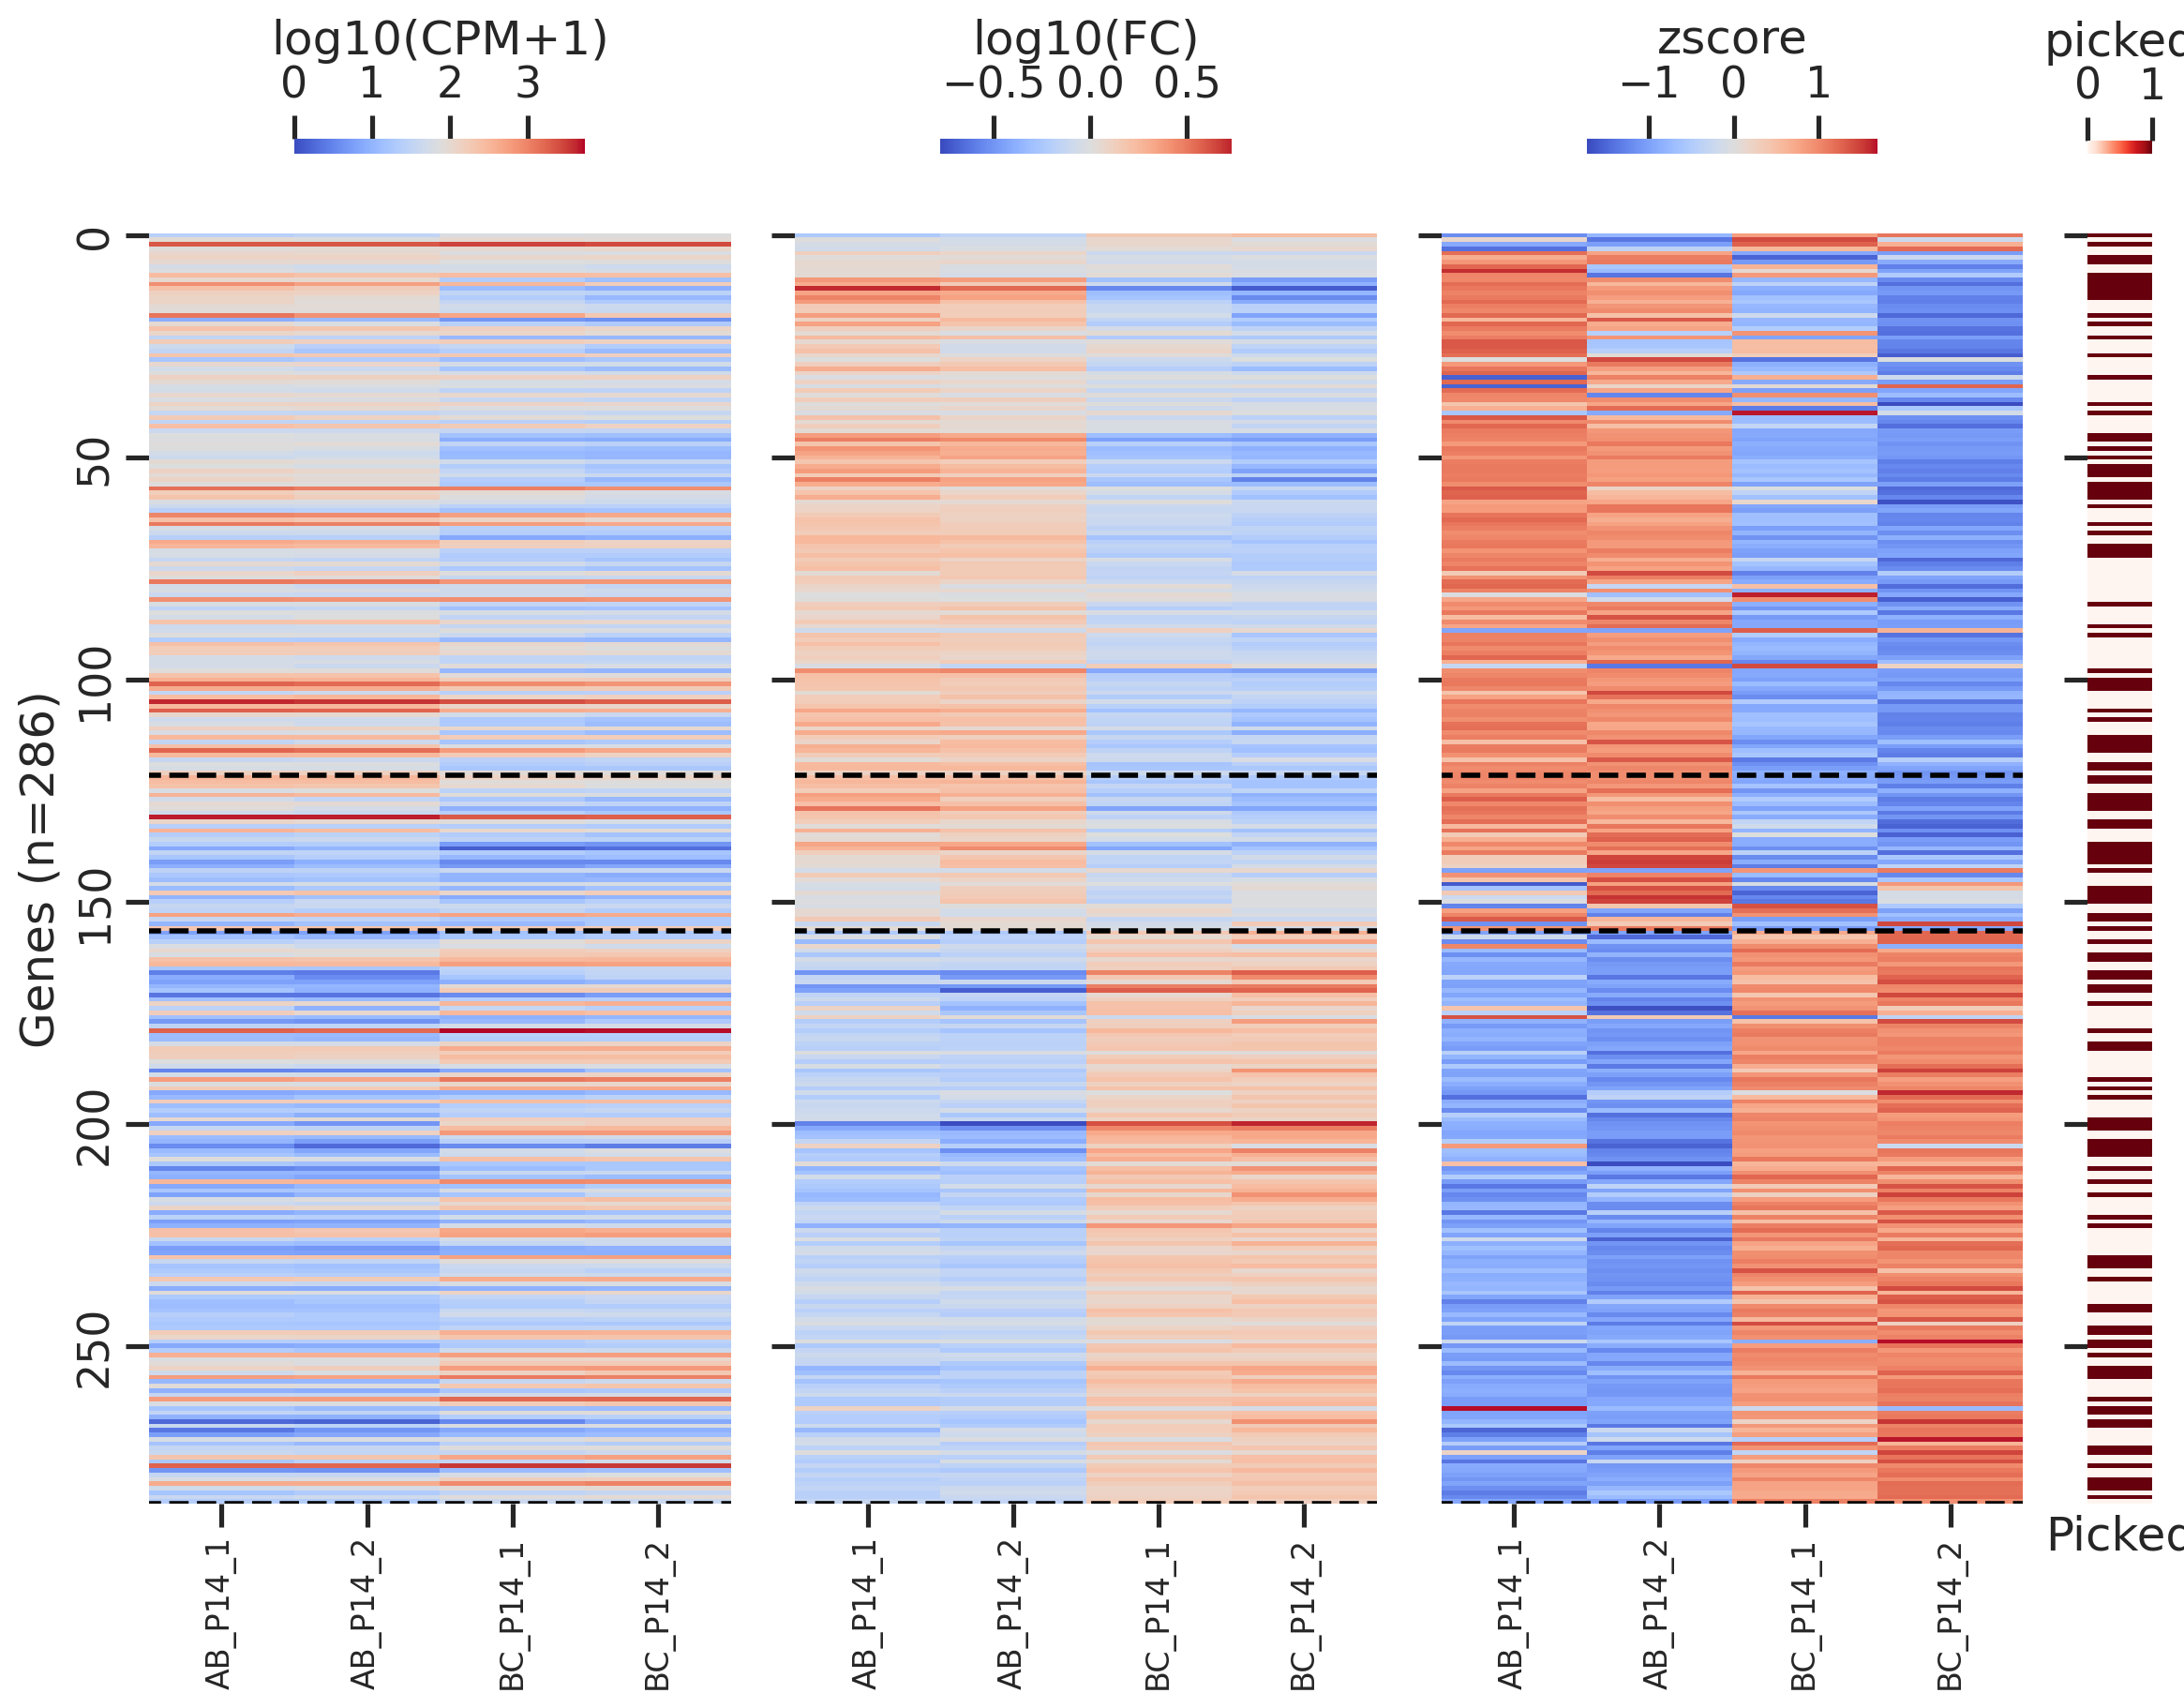

In [20]:

# fig, axs = plt.subplots(1, 3, figsize=(3*4,10), sharey=True)

fig, axs = plt.subplot_mosaic("A"*5+"B"*5+"C"*5+"D", figsize=(3*4,10), sharey=True)
# fig.suptitle(f'L2/3 type genes \n(n={len(pbsub_a)})', fontsize=15)

ax = axs["A"]
sns.heatmap(pbsub, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(CPM+1)', ticks=[0,1,2,3]),
            vmin=0, 
            # vmax=3,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_ylabel(f'Genes (n={len(pbsub_a)})')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["B"]
sns.heatmap(pbsub_logfc, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='log10(FC)'),
            # vmin=0, 
            # vmax=3,
            center=0,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["C"]
sns.heatmap(pbsub_zscore, #[rowidx],
            yticklabels=50,
            xticklabels=xlbls_short, # tsdup,
            cmap='coolwarm', 
            cbar_kws=dict(location='top', shrink=0.5, label='zscore'),
            # vmin=0, 
            # vmax=3,
            center=0,
            ax=ax,
           )
# ax.set_xlabel('Samples')
ax.hlines(np.cumsum(gene_counts), xmin=-1, xmax=pbsub.shape[1]+1, color='black', linewidth=2, linestyle='--')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

ax = axs["D"]
sns.heatmap(ispicked.reshape(-1,1), #[rowidx],
            yticklabels=50,
            xticklabels=False, 
            cmap='Reds', 
            cbar_kws=dict(location='top', shrink=1, ticks=[0,1], label='picked', aspect=5),
            ax=ax,
           )
ax.set_xlabel('Picked')

fig.tight_layout()
plt.show()

In [21]:
def plot_l23genes(order=None):
    """
    """
    n = len(maxexp)
    if order is None:
        order = np.arange(n)
        
    fig, axs = plt.subplots(2,1,figsize=(1*10,2*3), sharex=True)
    ax = axs[0]
    ax.plot(maxexp[order], label='max type') #, color='C1')
    ax.plot(minexp[order], label='min type') #, color='k')
    ax.scatter(np.arange(n)[ispicked[order]], maxexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10(CPM+1)')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    ax = axs[1]
    ax.plot(lfcexp[order], color='k')
    ax.axhline(np.log10(2), color='gray', linestyle='--', label='2-fold')
    ax.scatter(np.arange(n)[ispicked[order]], lfcexp[order][ispicked[order]], s=5, color='r', zorder=2, label=f'picked n={ispicked.sum()}')
    ax.set_ylabel('log10FC\n(max type/min type)')
    ax.set_xlabel('L2/3 genes')
    sns.despine(ax=ax)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')

    fig.tight_layout()
    plt.show()

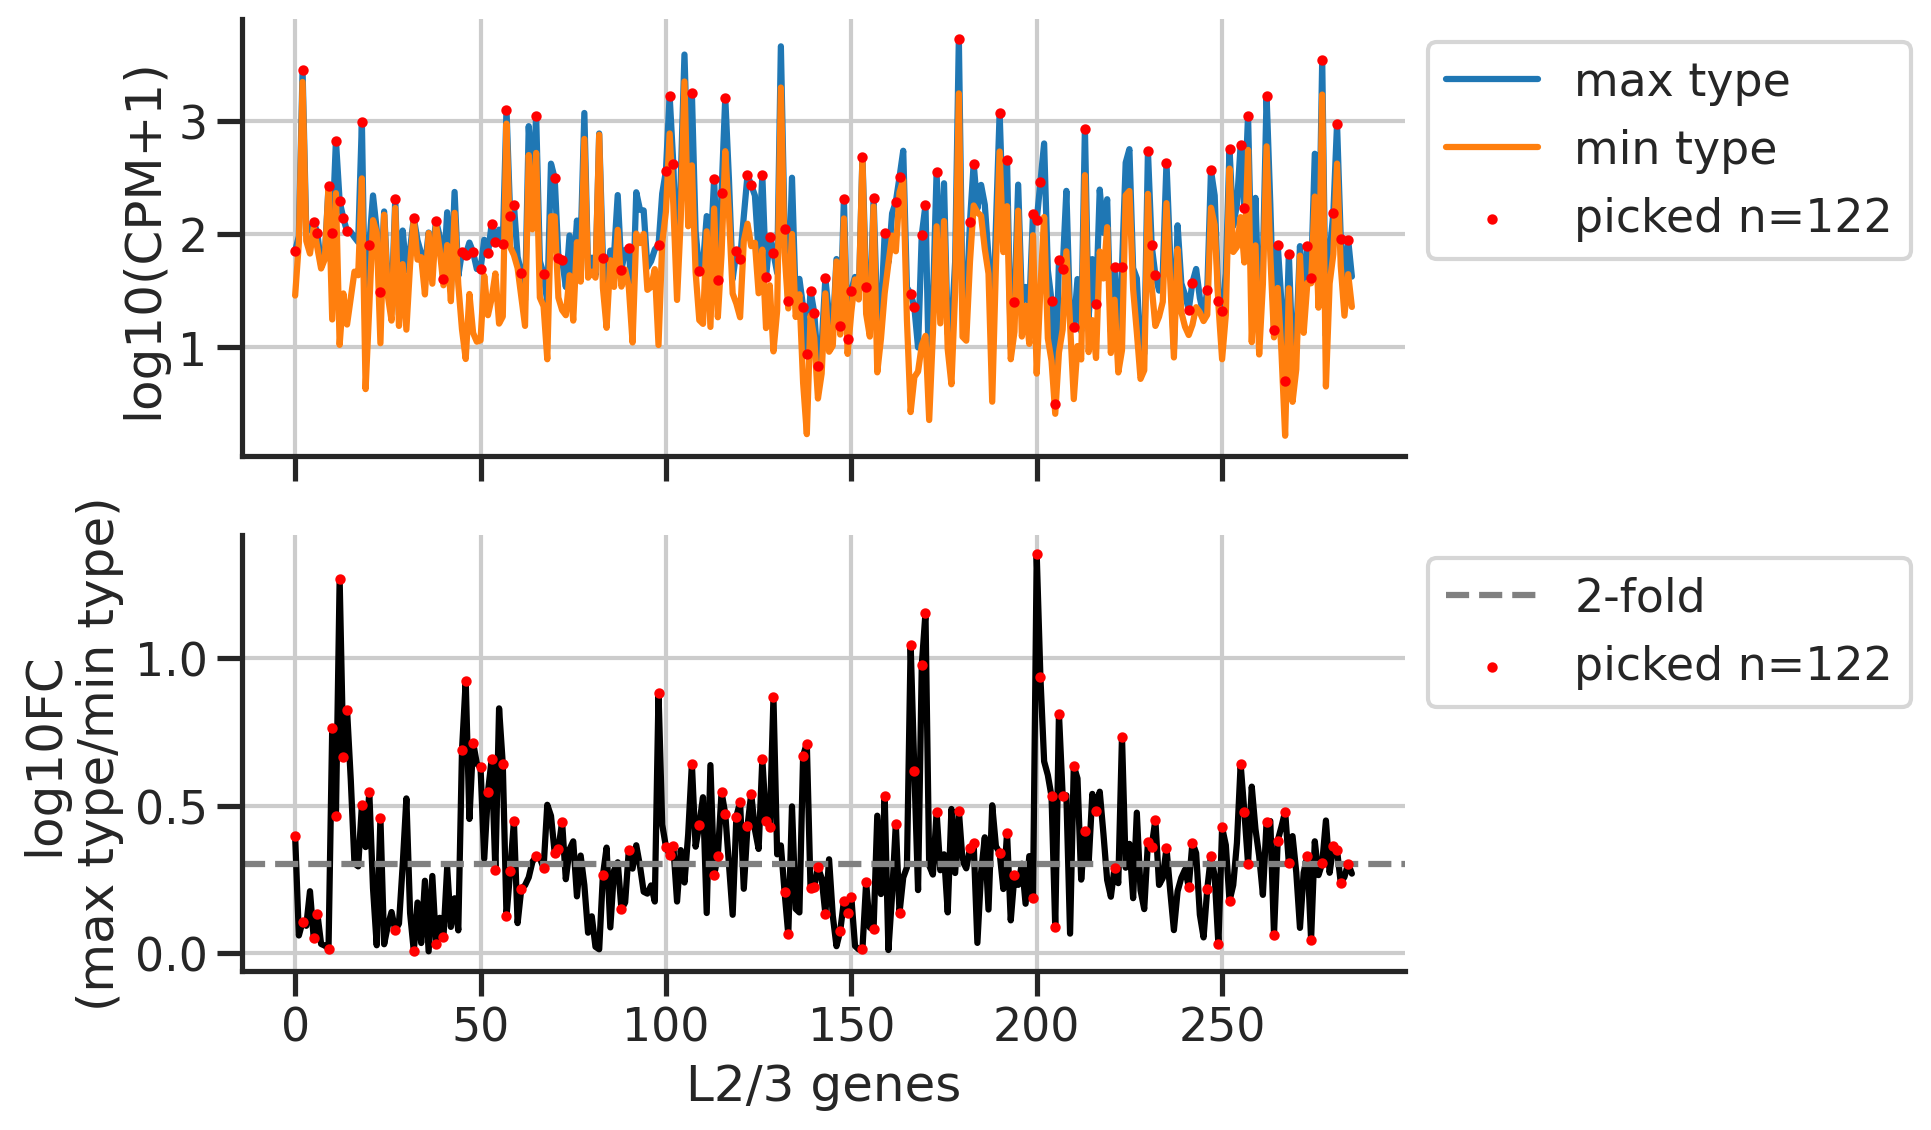

In [22]:
plot_l23genes()

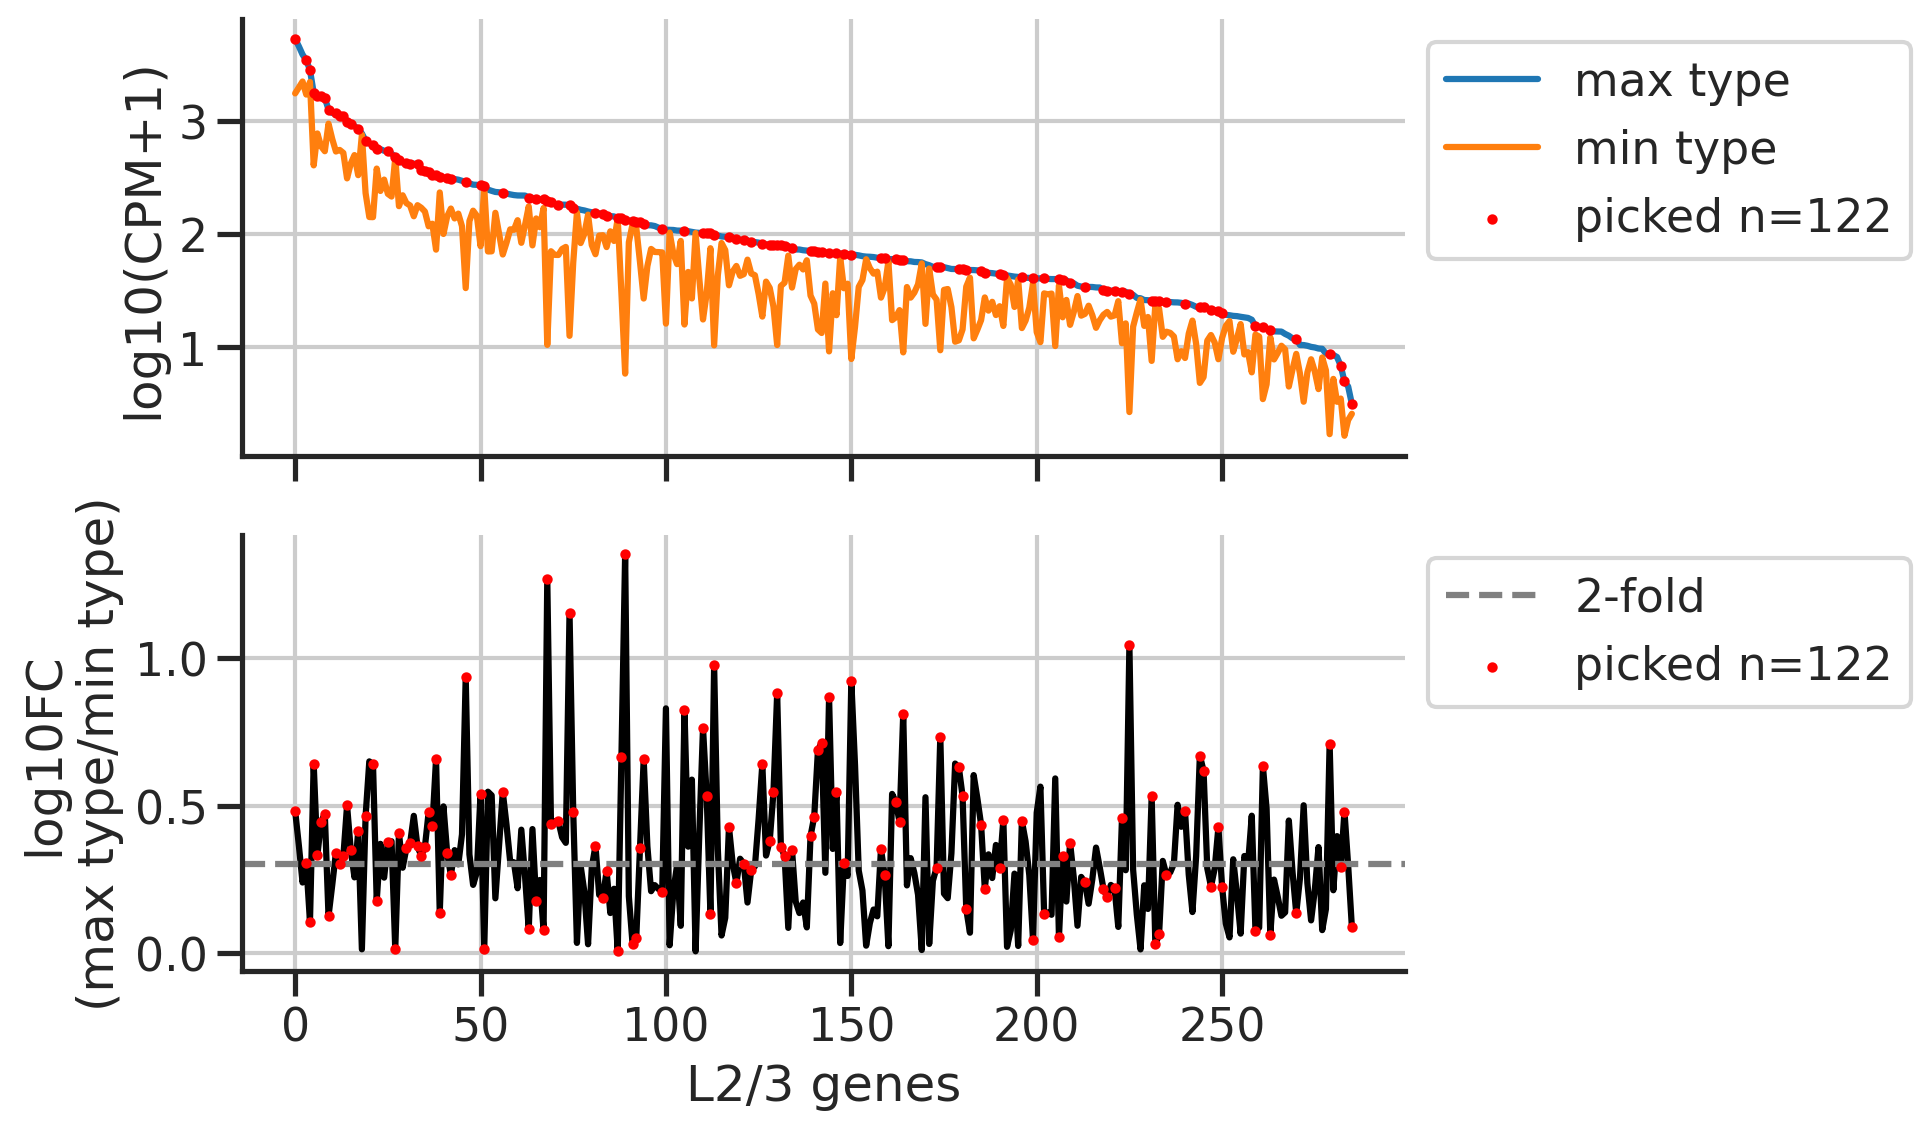

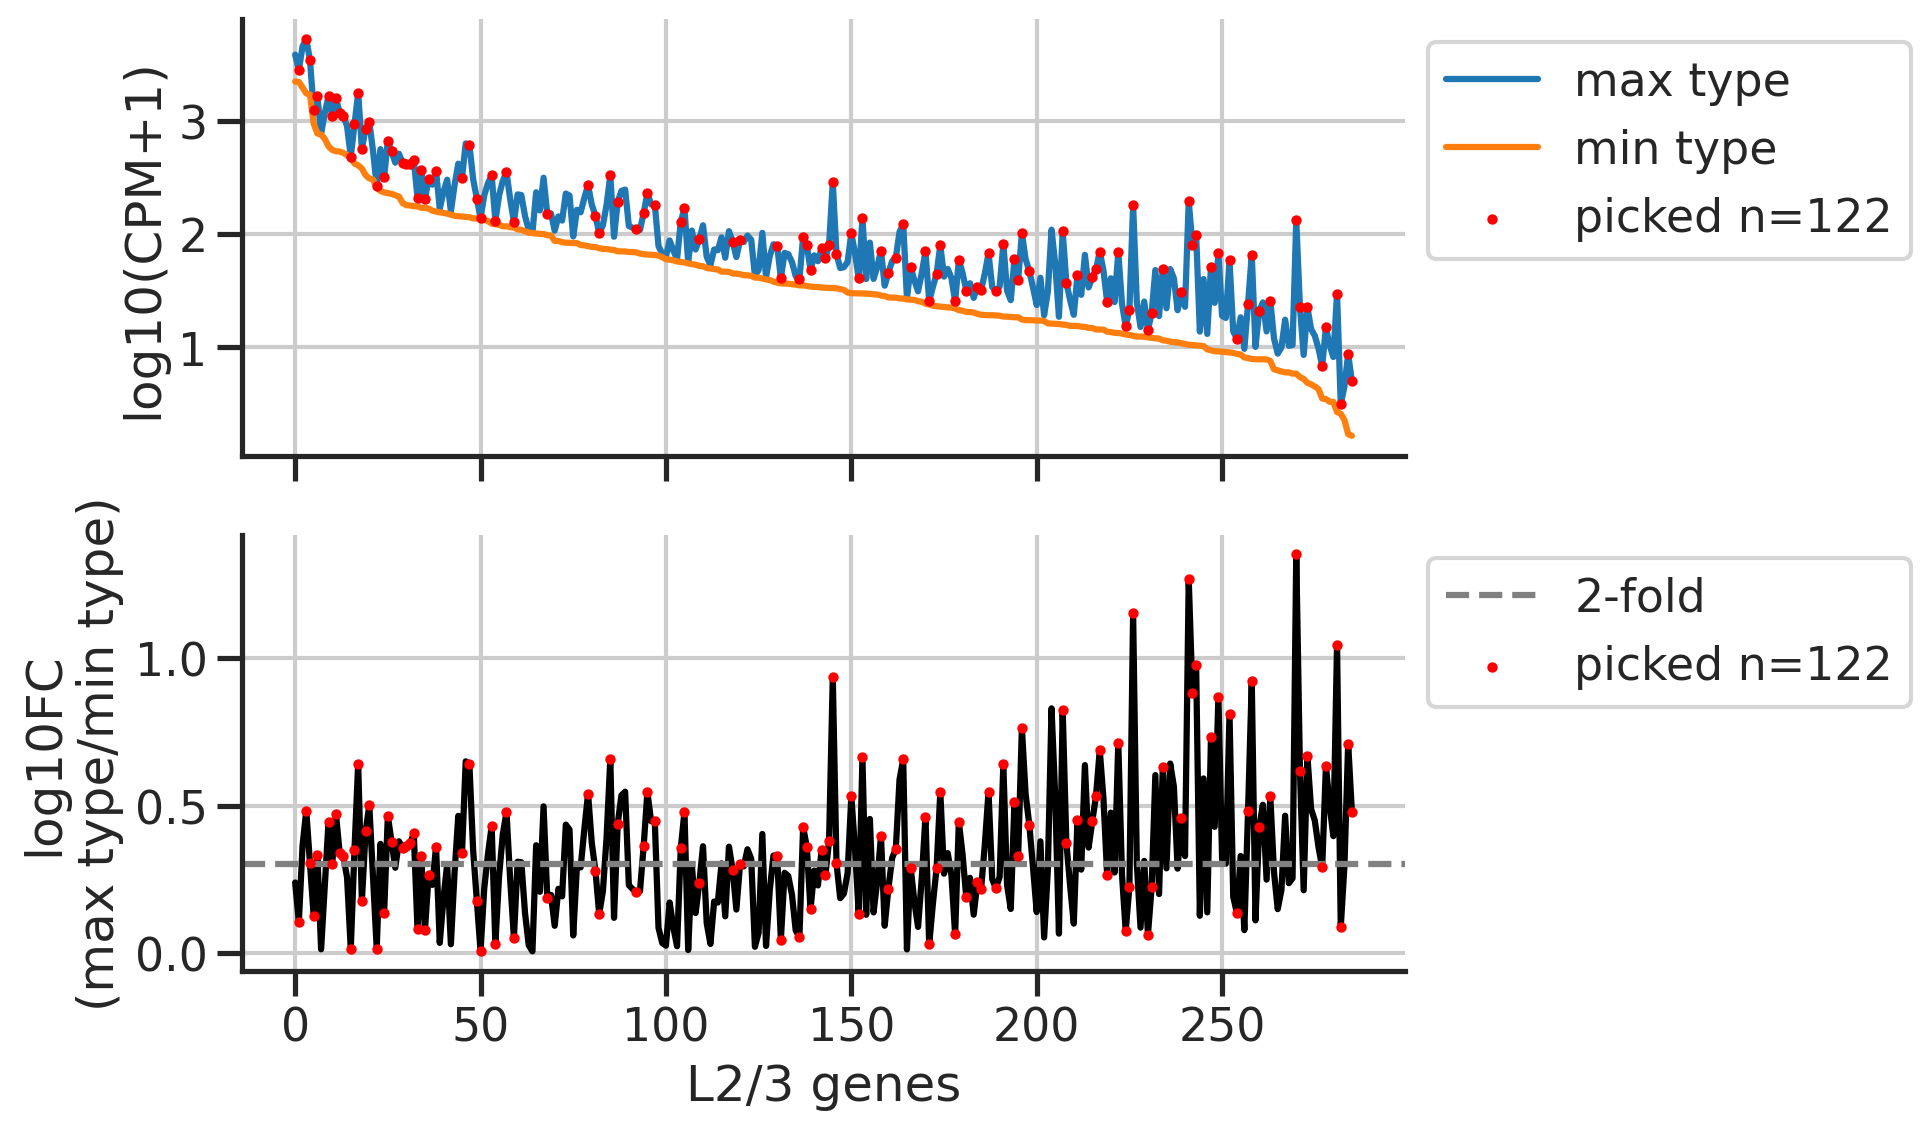

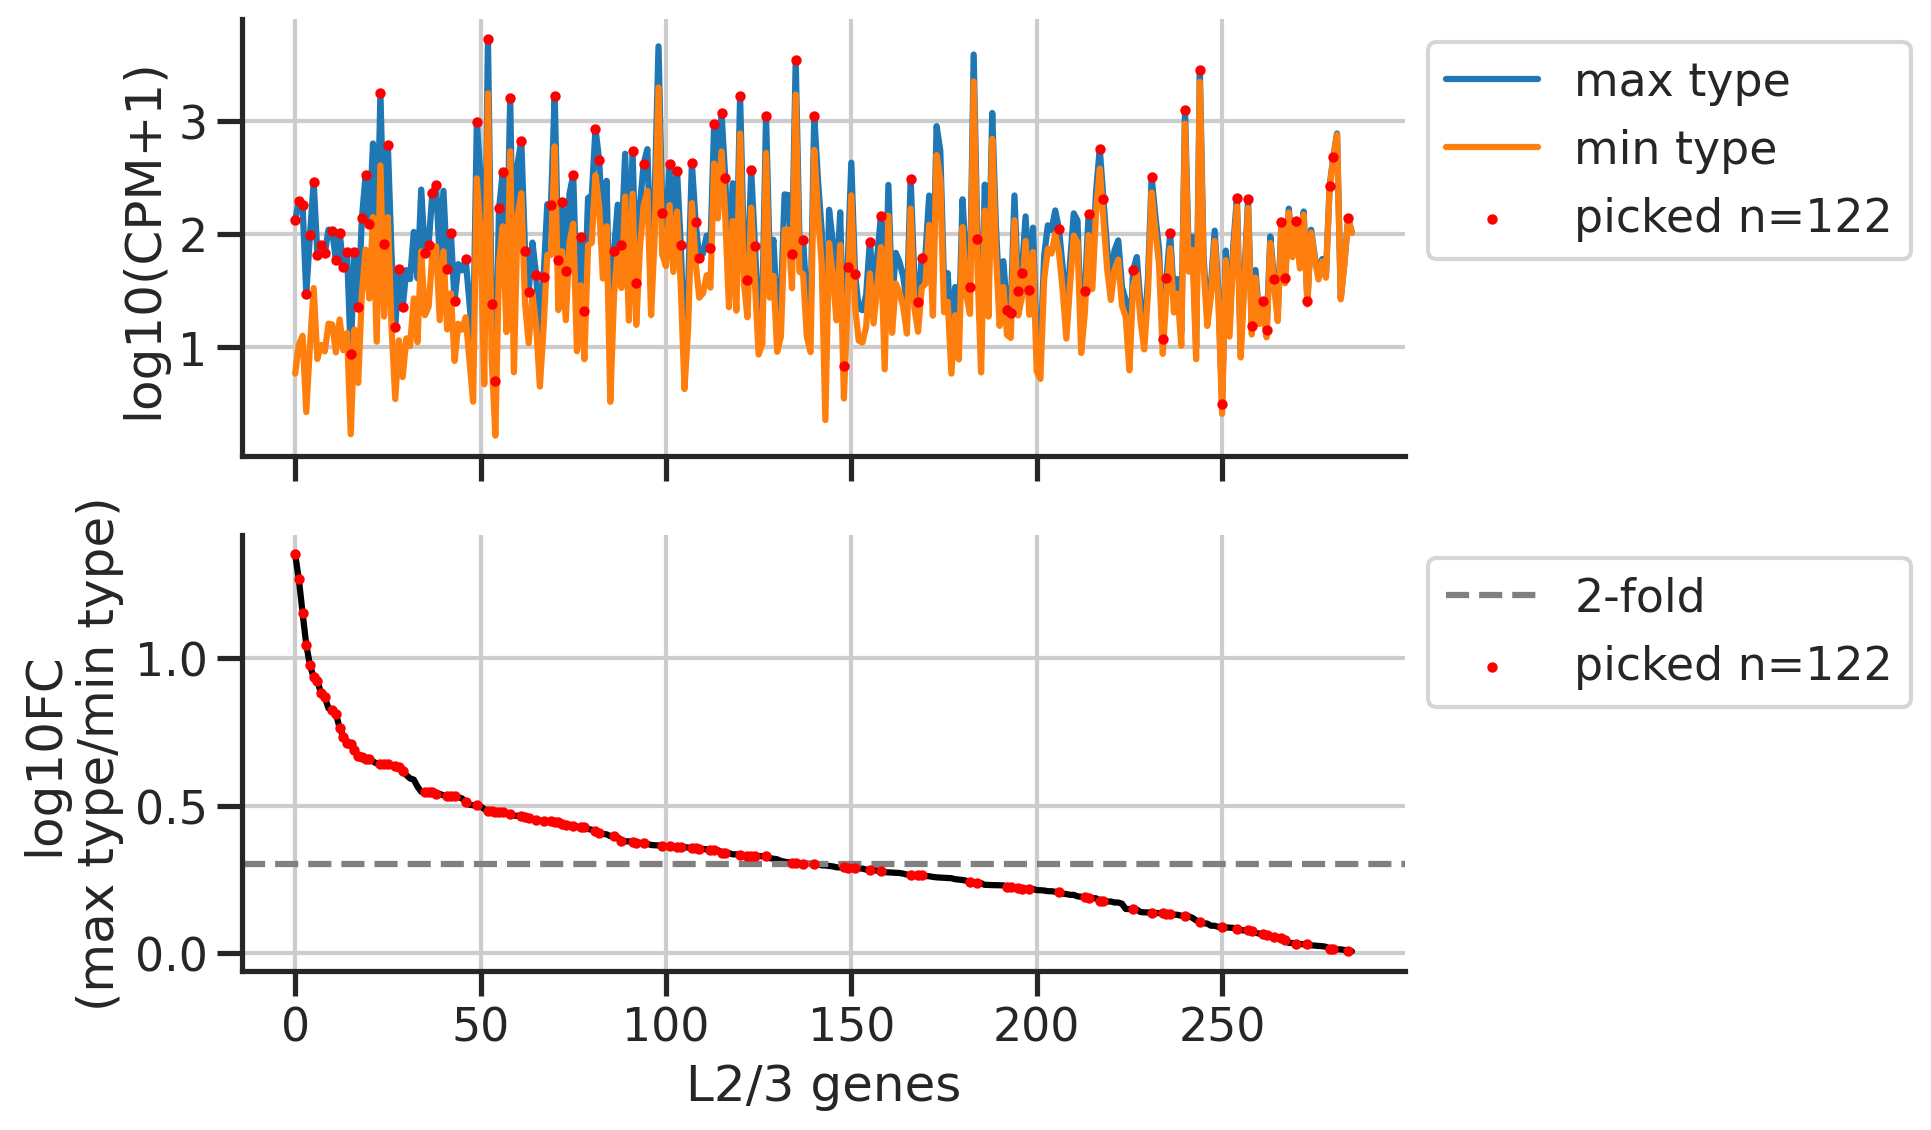

In [23]:
plot_l23genes(order=maxorder[::-1])
plot_l23genes(order=minorder[::-1])
plot_l23genes(order=lfcorder[::-1])

In [24]:
genes_l23[lfcexp < np.log10(2)]

1            Fam126a
2             Egfem1
3            Gm19410
4               Grk3
5              Grb14
           ...      
276         AI593442
279          Dennd4c
282             Ell2
283          Gm21949
285    3632451O06Rik
Name: 0, Length: 145, dtype: object

In [25]:
genes_l23[np.logical_and(lfcexp<np.log10(2), ispicked)]

2        Egfem1
5         Grb14
6      Adamts17
9          Ldb2
27        Nr3c2
32        Tiam1
38        Mdga1
40      Cacna1h
54        Glis3
57        Cntn5
58       Sema6a
61         Otof
67          Nov
83       Zfp608
88        Pdgfc
113       Meis2
132       Fstl5
133      Sema4a
139       Nell1
140        Bdnf
141       Nptx2
143        Nrp1
147       Npas4
148      Sorcs3
149       Baz1a
150      Phf21b
153      Pcdh15
154     Col11a1
156       Maml3
163     Runx1t1
194       Kcna1
199      Pantr1
205         Maf
221      Zfp618
241       Cntn2
246       Tshz1
249        Tle4
252       Scn1a
264     Col25a1
274      Igsf9b
282        Ell2
Name: 0, dtype: object

In [26]:
lfc_abvsbc = np.mean(pbsub_a, axis=1) - np.mean(pbsub_b, axis=1) 
lfc_abvsbc

array([-0.39582498, -0.05800955, -0.10481818, -0.09098599,  0.20855729,
        0.0503851 ,  0.13115241,  0.02918665,  0.02338884, -0.01342293,
        0.76399838,  0.46451331,  1.26916239,  0.66436373,  0.82526358,
        0.58802846,  0.30319361,  0.29300417,  0.50008322,  0.35862706,
        0.54547231,  0.21861474,  0.02468104,  0.45727956,  0.02820572,
        0.09119256,  0.13779037,  0.07514986,  0.09834202,  0.2966181 ,
        0.52412907,  0.13429253, -0.00510596,  0.17011392, -0.03238796,
        0.24414132, -0.00413594,  0.26041454,  0.02927356,  0.11804387,
       -0.05258944,  0.28962354,  0.08717202,  0.18445554,  0.07531279,
        0.68828274,  0.92297403,  0.45430911,  0.71403322,  0.64272796,
        0.62943636,  0.31900947,  0.54572572,  0.65716436,  0.28058176,
        0.83036258,  0.64065693,  0.12386808,  0.27748006,  0.44612622,
        0.10007647,  0.21765702,  0.22862299,  0.25566954,  0.30892585,
        0.32671539,  0.321093  ,  0.28731004,  0.50253871,  0.46

(286,)

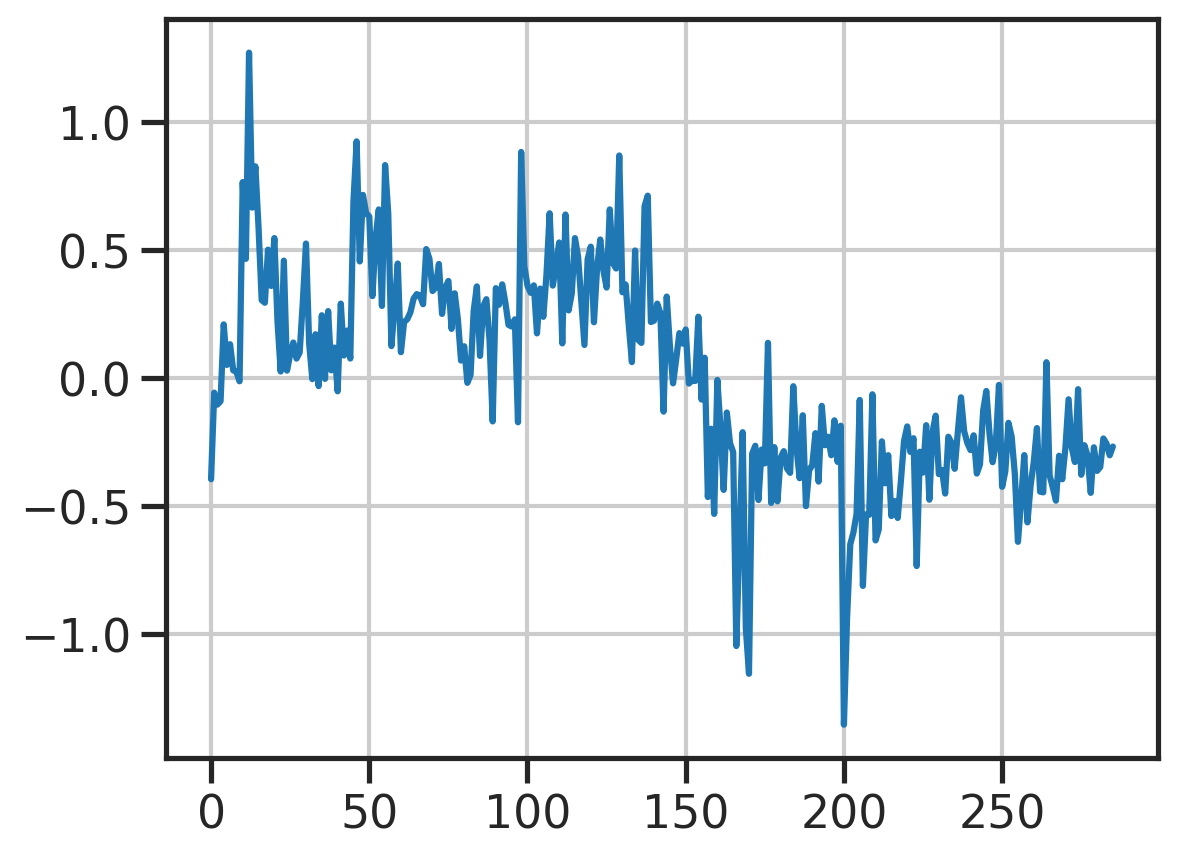

In [27]:
plt.plot(lfc_abvsbc)
lfc_abvsbc.shape

In [28]:
f = "../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq.csv"
df = pd.read_csv(f, header=None)
df

,0,1
0,Matn2,A2
1,Fam126a,A2
2,Egfem1,A2
3,Gm19410,A2
4,Grk3,A2
...,...,...
281,Brinp3,C3
282,Ell2,C3
283,Gm21949,C3
284,Jdp2,C3


In [36]:
fout = "../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq_p14fc.csv"
dfout = df.copy()
dfout['P17on'] = dfout[1].apply(lambda x: x[0])
dfout['P14log10fc_abvsbc'] = lfc_abvsbc 
dfout['P14'] = "unsure" # lfc_abvsbc 
dfout.loc[lfc_abvsbc> np.log10(2), 'P14'] = "AB" # lfc_abvsbc 
dfout.loc[lfc_abvsbc<-np.log10(2), 'P14'] = "BC" # lfc_abvsbc 
dfout['ispicked'] = ispicked
dfout


,0,1,P17on,P14log10fc_abvsbc,P14,ispicked
0,Matn2,A2,A,-0.395825,BC,True
1,Fam126a,A2,A,-0.058010,unsure,False
2,Egfem1,A2,A,-0.104818,unsure,True
3,Gm19410,A2,A,-0.090986,unsure,False
4,Grk3,A2,A,0.208557,unsure,False
...,...,...,...,...,...,...
281,Brinp3,C3,C,-0.348376,BC,True
282,Ell2,C3,C,-0.236756,unsure,True
283,Gm21949,C3,C,-0.257234,unsure,False
284,Jdp2,C3,C,-0.302420,BC,True


In [37]:
dfout.groupby(['P17on', 'P14']).size()

P17on  P14   
A      AB        56
       BC         1
       unsure    65
B      AB        14
       unsure    21
C      BC        70
       unsure    59
dtype: int64

In [38]:
dfout.to_csv(fout, sep='\t', header=True, index=False)

In [39]:
dfout.groupby(['P17on', 'P14']).size().unstack().fillna(0).astype(int)

P14,AB,BC,unsure
P17on,,,
A,56,1,65
B,14,0,21
C,0,70,59


In [40]:
dfout

,0,1,P17on,P14log10fc_abvsbc,P14,ispicked
0,Matn2,A2,A,-0.395825,BC,True
1,Fam126a,A2,A,-0.058010,unsure,False
2,Egfem1,A2,A,-0.104818,unsure,True
3,Gm19410,A2,A,-0.090986,unsure,False
4,Grk3,A2,A,0.208557,unsure,False
...,...,...,...,...,...,...
281,Brinp3,C3,C,-0.348376,BC,True
282,Ell2,C3,C,-0.236756,unsure,True
283,Gm21949,C3,C,-0.257234,unsure,False
284,Jdp2,C3,C,-0.302420,BC,True


In [41]:
dfout[ispicked].groupby(['P17on', 'P14']).size().unstack().fillna(0).astype(int)

P14,AB,BC,unsure
P17on,,,
A,32,1,16
B,8,0,13
C,0,40,12


In [45]:
dfout.groupby(['ispicked', 'P14', 'P17on',]).size() #.unstack().fillna(0).astype(int)

ispicked  P14     P17on
False     AB      A        24
                  B         6
          BC      C        30
          unsure  A        49
                  B         8
                  C        47
True      AB      A        32
                  B         8
          BC      A         1
                  C        40
          unsure  A        16
                  B        13
                  C        12
dtype: int64